**Chapter 4**
___
# **Estimating Proportions**
Previously in the **101 Bowls Problem**, it was not about guessing which bowl the cookies came from; it was about estimating proportions.
Here, with the $\text{Euro Problem}$ we take another step forward toward Bayesian Statistics.
<br>
<br>
## **The Euro Problem**
___
In $Information \space Theory, \space Inference, \space Learning \space Algorithms$, David MacKay poses the following problem:

* *When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. "It looks very suspicious to me", said Barry Blight, a statistics lecturer at the $London \space School \space of \space Economics.$ "If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%"*  

  But do these data give evidence that the coin is biased rather than fair?

To answer the question we'll proceed in two steps. First one is Binomial distribution to see where that 7% came from; then we'll use Bayes' Theorem to estimate the probability that this coin comes up heads.

### **The Binomial Distribution**
___

* Probability of heads is $p$ and he spin the coin $n$ times. The probability that we get a total of $k$ heads is given by **binomial distribution** 
\begin{equation}
{n\choose k}p^k(1-p)^{n-k} 
\end{equation}

for any value of $k$ from 0 to $n$, including both. ( Term ${n\choose k}$ means $n$ choose $k$)

For Example, if we flip a coin $n=2$ times and the prob of heads is $p=0.5$, here's the probabilty of getting $k=1$ heads:

### ** First we import the libraries that we are using**

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
try:
  from empiricaldist import Pmf
except:
  !pip install empiricaldist

In [69]:


n=2
p=0.5
k=1
binom.pmf(k, n, p)

0.5

Instead of providing single value for $k$, we can also call binom.pmf with an array of values:

In [70]:

ks = np.arange(n+1)
ps=binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

Usually a coin toss outcome should look like this:


|chooice ↓ /outcome  ↘ | H | T |
|--|---|---|
|H | 1 | 0 |
|T | 0 | 1 |

If we toss the coin n=2 times:

| TT(0) | HT(1) | HH(2) |
|-------| ----- | ----- |
| 0.25  | 0.50  | 0.25  |  

The result is a Numpy array with probability of -
* 0 Heads (This hypothesis suggests that both times we'll get tails - TT), 
* 1 Head (This hypothesis suggests that we'll get Heads and tails 1 time each - HT), 
* 2 Heads (This hypothesis suggests that we'll get Heads twice - HH) heads, 

If we put these probabilities in a `Pmf`, the result is the distribution of $k$ for the given values of $n$ and $p$

In [71]:
pmf_k = Pmf(ps,ks) # first parameter is the series of prior probabilites and second are the hypotheses
pmf_k

,probs
0,0.25
1,0.50
2,0.25


The following function computes the binomial distribution for given values of $n$ and $p$ and returns a `Pmf` that represents the result:

In [72]:
def make_binomial(n,p):
  ks = np.arange(n+1) # hypothesis maker
  ps = binom.pmf(ks,n,p) # 250 hypothesis, n = number of times coin tossed, p = prior probabilty
  return Pmf(ps,ks) # ps = probabilities, ks=hypothesis

Here's what it looks like with `n=250` and `p=0.5` : 

In [73]:
pmf_k = make_binomial(n= 250, p = 0.5)
pmf_k

,probs
0,5.527148e-76
1,1.381787e-73
2,1.720325e-71
3,1.422135e-69
4,8.781685e-68
...,...
246,8.781685e-68
247,1.422135e-69
248,1.720325e-71
249,1.381787e-73


In [74]:

pmf_kp=pd.DataFrame(columns=['probs'])
pmf_kp['probs']=pmf_k
pmf_kp

,probs
0,5.527148e-76
1,1.381787e-73
2,1.720325e-71
3,1.422135e-69
4,8.781685e-68
...,...
246,8.781685e-68
247,1.422135e-69
248,1.720325e-71
249,1.381787e-73


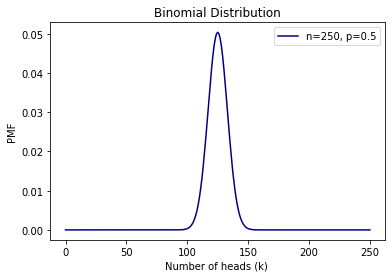

In [75]:


plt.title("Binomial Distribution")
plt.ylabel("PMF")
plt.xlabel("Number of heads (k) ")
plt.plot(pmf_kp, color='navy')
plt.legend(['n=250, p=0.5'])
plt.show()

The most likely quantity in this distribution is 125:

In [76]:
pmf_k.max_prob()

125

In [77]:
pmf_k[125] # The probability that we get exactly 125 heads

0.05041221314731537

In [78]:
pmf_k[140] # From MacKay's Example, we got 140 heads, which is even less likely than 125:

0.008357181724917673

In the article the statistician says, "If the coin were unbiased the chances of getting a result as extreme as that would be less than 7%"

We can use the binomial distribution to check his math:

The following function takes a $\text{PMF}$ and computes the total probability of quantities greater than or equal to threshold(in this case 140):

In [79]:
def prob_ge(pmf, threshold):
  """Probability of quantities greater than or equal to threshold"""
  ge = (pmf.qs >=threshold)
  total = pmf[ge].sum()
  return total 

prob_ge(pmf_k,140) 

0.033210575620022706

The result is 3.3% which is less than the quoted 7%.

In [80]:
def prob_le(pmf, threshold):
  """Probability of quantities less than or equal to threshold"""
  le = (pmf.qs <=threshold)
  total = pmf[le].sum()
  return total 

prob_le(pmf_k,110) 

0.033210575620022706

The probability of outcomes less than or equal to 110 is also 3.3%, so the total probailtiy of outcomes "as extreme" as 140 is 6.6%

The point of this calculation is that these extreme outcomes are unlikely if the coin is fair.

That's interesting, but it doesn't answer MacKay's question. Let's see if we can.

## **Bayesian Estimation**
___

Any given coin has some probability of landing heads up when spun on edge; Let's call that $x$. It is rational to think $x$ depends on the physical characteristics of the coin, like that distribution of the weight. A balanced coin would have $x ≈ 0.50$ . But with a lopsided(one side smaller than the other) coin, $x$ might be substantially different. Bayes' Theorem can be used to estimate $x$ with the observed data.

For simplicity, we'll start with a uniform prior( assume all values of $x$ to be equal):

In [81]:
hypos = np.linspace(0,1,101) # gives 101 fractions between 0 to 1 divided by hundred
prior = Pmf(1,hypos)
prior

,probs
0.00,1
0.01,1
0.02,1
0.03,1
0.04,1
...,...
0.96,1
0.97,1
0.98,1
0.99,1


In [82]:
likelihood_heads = hypos
likelihood_tails = 1- hypos

In [83]:
likelihood ={
    'H': likelihood_heads,
    'T': likelihood_tails
}

In [84]:
dataset= 'H'*140 + 'T'*110 # Since the problem statement had these outcomes

In [85]:
dataset

'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT'

In [86]:
def update_euro(pmf,dataset):
  for data in dataset:
    pmf *= likelihood[data]
  pmf.normalize()

update_euro(prior, sequence_of_strings)


In [87]:
posterior = prior.copy()
update_euro(posterior,dataset)

In [88]:
posterior

,probs
0.00,0.000000e+00
0.01,1.256330e-207
0.02,5.731921e-166
0.03,8.338711e-142
0.04,8.269265e-125
...,...
0.96,2.107677e-83
0.97,1.624102e-96
0.98,2.911941e-115
0.99,9.293081e-148


In [89]:
def convert_pmf_df(pmf):
  results=pd.DataFrame(columns=['probs'])
  results['probs']=pmf
  return results

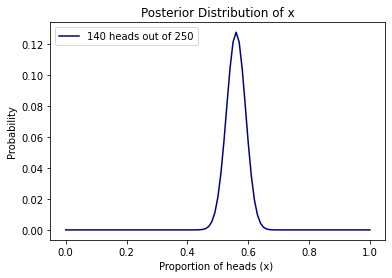

In [90]:
plt.title("Posterior Distribution of x")
plt.ylabel("Probability")
plt.xlabel("Proportion of heads (x) ")
plt.plot(convert_pmf_df(posterior), color='navy')
plt.legend(['140 heads out of 250'])
plt.show()

In [91]:
posterior.max_prob()

0.56

The figure shows that $x$ is unlikely when less than 0.4 and more than 0.7 and values between 0.5 and 0.6 are most likely.

Infact, the most likely value for $x=0.56$, which is the proportion of heads in the dataset, 140/250.

### **Triangle Prior**
___


In [92]:
hypos

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [93]:
uniform = Pmf(1,hypos, name ='uniform')
uniform.normalize()
uniform

,probs
0.00,0.009901
0.01,0.009901
0.02,0.009901
0.03,0.009901
0.04,0.009901
...,...
0.96,0.009901
0.97,0.009901
0.98,0.009901
0.99,0.009901


In [94]:
ramp_up = np.arange(50) # an array of 0 to 50
ramp_down = np.arange(50, -1,-1) # an array of 50 to 0

In [95]:
a = np.append(ramp_up, ramp_down) #concatenates the two 
triangle =Pmf(a,hypos,name='Triangle')
triangle.normalize()

2500

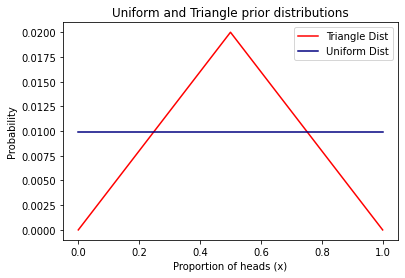

In [96]:
plt.title("Uniform and Triangle prior distributions")
plt.ylabel("Probability")
plt.xlabel("Proportion of heads (x)")
plt.plot(convert_pmf_df(triangle), color='red')
plt.plot(convert_pmf_df(uniform), color='navy')
plt.legend(['Triangle Dist','Uniform Dist'])
plt.show()

Now we can update both priors with the same data:

In [97]:
update_euro(uniform,dataset)
update_euro(triangle,dataset)

Here are the posteriors:

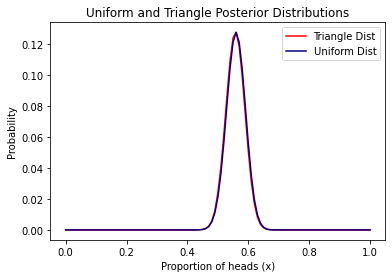

In [98]:
plt.title("Uniform and Triangle Posterior Distributions")
plt.ylabel("Probability")
plt.xlabel("Proportion of heads (x)")
plt.plot(convert_pmf_df(triangle), color='red')
plt.plot(convert_pmf_df(uniform), color='navy')
plt.legend(['Triangle Dist','Uniform Dist'])
plt.show()

The difference between the posterior distributions are barely visible and so smal they would hardly matter in practice.

So, both *Uniform distribution* and *Triangle Distribution* as prior are pretty close in generating satisfying posteriors.

Above is an example of **swamping the priors**: with enough data, when started with different priors(uniform or triangle) eventually will tendo converge on the same posterior distribution.

### **The Binomial Likelihood Function**
___

So far we've been computing the updates one spin at a time, so far for the Euro Problem, it is ideal to compute the likelihood of the entire dataset all at once. For each hypothetical value of $x$, we have to compute the probability of getting 140 head out of 250 spins.

We know for $n$ spins, $k$ heads, probability of heads $p$ is:

\begin{equation}
{n\choose k}p^k(1-p)^{n-k} 
\end{equation}

In [99]:
def update_binomial(pmf,data):
  k, n = data
  xs = pmf.qs # here xs are are probabilities p
  likelihood = binom.pmf(k,n, xs)
  pmf *= likelihood 
  pmf.normalize()

In [100]:
uniform2 = Pmf(1,hypos, name ='uniform2')
data = 140,250 
update_binomial(uniform2,data)

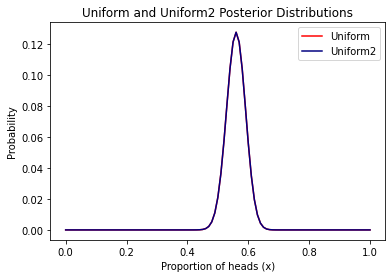

In [105]:
plt.title("Uniform and Uniform2 Posterior Distributions")
plt.ylabel("Probability")
plt.xlabel("Proportion of heads (x)")
plt.plot(convert_pmf_df(uniform), color='red')
plt.plot(convert_pmf_df(uniform2), color='navy')
plt.legend(['Uniform','Uniform2'])
plt.show()

In [106]:
np.allclose(uniform,uniform2)

True